In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.decomposition import PCA

In [2]:
train = pd.read_csv('ProjData.csv')

In [3]:
train = train.fillna(train.median())

In [4]:
scaler = StandardScaler()
scaler.fit(train)
train_s = scaler.transform(train)
train_s = pd.DataFrame(train_s, index=train.index, columns=train.columns)
train_s.sort_values(by = 'population', inplace = True)
train_s.index = range(0,len(train_s))
train_s1 = train_s[train_s.index > len(train_s)/2]
train_s2 = train_s[train_s.index < len(train_s)/2]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
X1 = train_s1.drop(['net_mig'], axis = 1)
y1 = train_s1['net_mig']
X2 = train_s2.drop(['net_mig'], axis = 1)
y2 = train_s2['net_mig']

In [6]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = .2, random_state = 99)
x_tr1, x_val1, y_tr1, y_val1 = train_test_split(X_train1, y_train1, test_size = .2, random_state = 99)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size = .2, random_state = 99)
x_tr2, x_val2, y_tr2, y_val2 = train_test_split(X_train2, y_train2, test_size = .2, random_state = 99)

In [7]:
param_dict = {"tol": [.0001], "eta0": [.01]}
lreg = SGDRegressor(tol=.0001, eta0=.01)
gs = GridSearchCV(lreg, param_dict, scoring = 'neg_mean_squared_error', cv = 4)
gs.fit(x_tr1, y_tr1)

predictions = gs.predict(X_test1)
mse = mean_squared_error(y_test1, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 1.6882909825452284


In [8]:
gs.fit(x_tr2, y_tr2)

predictions = gs.predict(X_test2)
mse = mean_squared_error(y_test2, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.05369671361138082


When split into two parts (splitting at the median level of population), the model for the larger segment of the population is very accurate, but the one for the smaller segment of the population is much much worse. This suggests that the main difficulty of this problem is predicting migration for the smallest counties. This is reinforced by the results from our classification models. Because they did not get good results, it shows that it is very hard to predict which side of 0 migration will be on- this is likely to be hardest for the smallest counties where the amount of migration is close to 0 already.

Let's try one last thing- we'll run PCA on the data and see if we can get a better result by removing some of the less important variation.

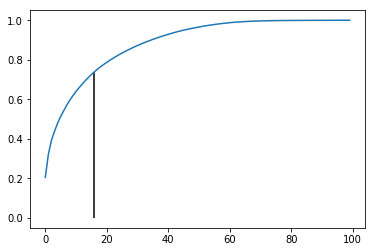

In [9]:
pca = PCA(n_components=100)
train1_pca = pca.fit_transform(X1)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[16],x=16)

Looks like here the elbow is around 16, so we'll use that as our number of components. We want to keep a good deal of variance without having too many dimensions that can bring in spurious correlations that will muddle our regression.

In [10]:
pca16 = PCA(n_components=16)
train1_pca16 = pca16.fit_transform(X1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(train1_pca16, y1, test_size = .2, random_state = 99)
x_tr1, x_val1, y_tr1, y_val1 = train_test_split(X_train1, y_train1, test_size = .2, random_state = 99)
gs.fit(x_tr1, y_tr1)

predictions = gs.predict(X_test1)
mse = mean_squared_error(y_test1, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 1.2389531872173727


So the PCA transformation did not help our RMSE improve. Looks like we did not have a bunch of extra unhelpful variables.

Let's try again with our second half of the data.

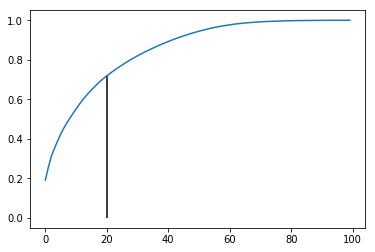

In [11]:
train2_pca = pca.fit_transform(X2)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[20],x=20)

The elbow here is around 20, so we'll use 20 principle components.

In [12]:
pca20 = PCA(n_components=20)
train2_pca20 = pca20.fit_transform(X2)

X_train2, X_test2, y_train2, y_test2 = train_test_split(train2_pca20, y2, test_size = .2, random_state = 99)
x_tr2, x_val2, y_tr2, y_val2 = train_test_split(X_train2, y_train2, test_size = .2, random_state = 99)
gs.fit(x_tr2, y_tr2)

predictions = gs.predict(X_test2)
mse = mean_squared_error(y_test2, predictions)
print("RMSE: {}".format(np.sqrt(mse)))

RMSE: 0.05563350263763376


This also was not helpful in improving the RMSE of our model.